<h3> Load Libraries </h3>

In [1]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Helpers:
    def __init__(self):
        print("Helper")
        
    def convert_missing_values_nan(df):
        '''This function will convert -9999 to NaN'''
        df = df.replace(-9999.000000, np.NaN)
        return df

    def drop_nan_columns(df):
        '''Drops the columns having all theirs rows as Nans'''
        columns_to_exclude = ["Date", "Day", "Year", "Month", "Timestamp start"
                              , "Time", "TIMESTAMP", "Tier", "TIMESTAMP_START", "TIMESTAMP_END", "Day Status"]
        columns = df.columns
        for i in range(len(columns)):
            col = columns[i]
            if col in columns_to_exclude:
                continue
            nan_sum_col = df[col].isnull().sum()
            if nan_sum_col == len(df):
                df.drop(col, axis=1, inplace=True)
        return df
    
    def drop_nans_rows(df):
        '''This function will drop the rows having NaNs'''
        print("Before removing missing values:")
        print("number of rows:", df.shape[0], "\nnumber of columns:", df.shape[1])
        df = df.dropna(how='any')
        print("After removing missing values:")
        print("number of rows:", df.shape[0], "\nnumber of columns:", df.shape[1])
        return df
        
    def get_all_matching_columns(df, keyword):
        return df.filter(like=keyword).columns

    def generate_lags(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
#             for j in range(i):
#                 df.loc[str(j+1), lag_name] = np.nan
#         df = df.dropna(how='any')
        return df

    def add_LE_conversion_rate(df, col):
        conversion_rate = 28.94
        new_col = col + "(mm)"
        df[new_col] = df[col] / conversion_rate
        return df

    def read_sites_data():
        file_path = os.path.join(base_path, "filtered_sites_all.xlsx")
        df = pd.read_excel(file_path)
        df.head()
        return df

    def export_data(df, file_path):
        export_path = os.path.join(base_path, file_path + ".csv")
        export_csv = df.to_csv(export_path, index=None, header=True)

    def load_data(file_path):
        df = pd.read_csv(file_path + ".csv", delimiter=',')
        return df
    
    def list_to_df(list_to_convert):
        '''This function will convert the provided list into a dataframe'''
        df = pd.concat(list_to_convert, sort=True)
        return df
    
    def get_files_directory(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
        listOfFile = os.listdir(dirName)
        allFiles = list()
        # Iterate over all the entries
        for entry in listOfFile:
            # Create full path
            if entry.endswith(".xlsx") or entry.endswith(".icloud") or entry.endswith(".DS_Store"):
                continue
            fullPath = os.path.join(dirName, entry)
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath):
                allFiles = allFiles + Helpers.get_files_directory(fullPath)
            else:
                allFiles.append(fullPath)

        return allFiles

    def concat_dataframe_from_files(files, skipRowsNum, split_num):
        values = []
        for i in range(len(files)):
            file_path = files[i]
            head, file_name = os.path.split(file_path)
            #Get only the sheets having the variables
            if file_name.endswith(".csv"):
#                 print("file name", file_name)
                df = pd.read_csv(file_path, delimiter=',', skiprows=skipRowsNum)
                site_id = file_name.split("_")[split_num]
#                 print("site id in file:", site_id)
                df["Site Id"] = site_id
                values.append(df)
        return Helpers.list_to_df(values)   
    
    def generate_dataframe_from_files(dirName, skipRowsNum = 0, split_num = 0):
        files = Helpers.get_files_directory(dirName)
        df = Helpers.concat_dataframe_from_files(files, skipRowsNum, split_num)
        return df
        

In [5]:
class EuroFlux:

    def __init__(self, input_path, output_path):
        print("Initializer")
        self.input_path = input_path
        self.output_path = output_path
        
    def unzip_folder(self, filename):
        if filename.endswith(".zip"):
            name = os.path.splitext(os.path.basename(filename))[0]
            path = self.input_path + name
            if not os.path.isdir(path):
                try:
                    zip = zipfile.ZipFile(filename)

                    os.mkdir(path)
                    zip.extractall(path=path)
                    zip.close()
                    os.remove(filename)
                except:
                    print("BAD ZIP: ", filename)
        
    def unzip_folders(self):
        files = Helpers.get_files_directory(input_path)
        for i in range(len(files)):
            file = files[i]
            head, file_name = os.path.split(file)
            if file_name.endswith(".zip"):
                self.unzip_folder(file)
                
    def read_l2_data(self):
        files = Helpers.get_files_directory(input_path)
        l2_files = []
        df_list = []
        for i in range(len(files)):
            file = files[i]
            head, file_name = os.path.split(file)
            if file_name.endswith(".txt"):
                components = file_name.split("_")
                if components[1] == "L2":
                    print("L2 file:", file_name)
                    l2_files.append(file_name)
                    df = pd.read_csv(file , sep=",")
                    df["Site Id"] = components[3]
                    df["Year"] = components[4]
                    df["Version"] = components[5]
                    df_list.append(df)
                    
        return Helpers.list_to_df(df_list)

    def read_l3_data(self):
        files = Helpers.get_files_directory(input_path)
        l2_files = []
        df_list = []
        for i in range(len(files)):
            file = files[i]
            head, file_name = os.path.split(file)
            if file_name.endswith(".txt"):
                components = file_name.split("_")
                if len(components) > 2:
                    if components[2] == "L3":
                        print("L3 file:", file_name)
                        l2_files.append(file_name)
                        df = pd.read_csv(file , sep=",")
                        df["Site Id"] = components[3]
                        df["Year"] = components[4]
                        df["Version"] = components[5]
                        df_list.append(df)
                    
        return Helpers.list_to_df(df_list)
    
    def read_l4_data(self):
        files = Helpers.get_files_directory(input_path)
        l2_files = []
        df_list = []
        for i in range(len(files)):
            file = files[i]
            head, file_name = os.path.split(file)
            if file_name.endswith(".txt"):
                components = file_name.split("_")
                if len(components) > 2:
                    if (components[2] == "L4") and (components[3] == "h"):
                        print("L4 file:", file_name)
                        l2_files.append(file_name)
                        df = pd.read_csv(file , sep=",")
                        df["Site Id"] = components[4]
                        df["Year"] = components[5]
                        df["Version"] = components[6]
                        df_list.append(df)
                    
        return Helpers.list_to_df(df_list)
                    
input_path = "/Users/saraawad/Desktop/Datasets/Google/Euroflux/"
output_path = ""
ef = EuroFlux(input_path, output_path)
ef.unzip_folders()
df2_list = ef.read_l2_data()
df2_list.head()
print("-----------------------------------------")

df3_list = ef.read_l3_data()
df3_list.head()
print("-----------------------------------------")

df4_list = ef.read_l4_data()
df4_list.head()

Initializer
L2 file: EFDC_L2_Flx_FIJok_2002_v07_30m.txt
L2 file: EFDC_L2_Flx_ITCA2_2014_v014_30m.txt
L2 file: EFDC_L2_Flx_IECa1_2008_v02_30m.txt
L2 file: EFDC_L2_Flx_ITBCi_2010_v030_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2007_v09_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2013_v06_30m.txt
L2 file: EFDC_L2_Flx_FRAvi_2004_v01_30m.txt
L2 file: EFDC_L2_Flx_IECa1_2004_v03_30m.txt
L2 file: EFDC_L2_Flx_ITCA2_2012_v015_30m.txt
L2 file: EFDC_L2_Flx_ITCA2_2011_v06_30m.txt
L2 file: EFDC_L2_Flx_ITBCi_2014_v07_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2006_v07_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2015_v04_30m.txt
L2 file: EFDC_L2_Flx_ITCas_2007_v02_30m.txt
L2 file: EFDC_L2_Flx_ITCA2_2013_v017_30m.txt
L2 file: EFDC_L2_Flx_IECa1_2007_v02_30m.txt
L2 file: EFDC_L2_Flx_ITBCi_2008_v05_30m.txt
L2 file: EFDC_L2_Flx_ITCas_2008_v01_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2009_v07_30m.txt
L2 file: EFDC_L2_Flx_FRGri_2016_v05_30m.txt
L2 file: EFDC_L2_Flx_ITBCi_2006_v01_30m.txt
L2 file: EFDC_L2_Flx_FIJok_2001_v07_30m.txt
L2 file: EFDC_L2

,Day,DoY,GPP_or_ANN,GPP_or_MDS,GPP_st_ANN,GPP_st_MDS,H_f,H_fqc,Hour,LE_f,...,Ta_f,Ta_fqc,Ts_f,Ts_fqc,VPD_f,VPD_fqc,Version,Year,qf_NEE_or,qf_NEE_st
0,1,1.021,-0.141,-0.029,-0.248,-0.026,-26.67,0,0.5,2.19,...,8.12,0,8.31,0,-9999.0,-9999,v01.txt,2008,259,259
1,1,1.042,0.387,0.387,0.391,0.391,-25.78,0,1.0,2.06,...,7.78,0,8.25,0,-9999.0,-9999,v01.txt,2008,0,0
2,1,1.063,0.225,0.225,0.229,0.229,-29.29,0,1.5,1.25,...,7.43,0,8.20,0,-9999.0,-9999,v01.txt,2008,0,0
3,1,1.083,0.321,0.321,0.325,0.325,-25.95,0,2.0,1.05,...,7.62,0,8.14,0,-9999.0,-9999,v01.txt,2008,0,0
4,1,1.104,0.225,0.225,0.229,0.229,-33.06,0,2.5,0.72,...,7.31,0,8.10,0,-9999.0,-9999,v01.txt,2008,0,0


In [6]:
print(df2_list.columns)
print(df3_list.columns)
print(df4_list.columns)

Index(['ALB', 'APAR', 'CH4', 'CO2', 'DTime', 'D_SNOW', 'FC', 'FCH4',
       'FC_SSITC_TEST', 'FETCH_70', 'FETCH_90', 'FETCH_MAX', 'FO3', 'G', 'G_2',
       'H', 'H2O', 'H_SSITC_TEST', 'LE', 'LE_SSITC_TEST', 'LW_IN', 'LW_OUT',
       'MO_LENGTH', 'NDVI', 'NEE_PI', 'NETRAD', 'O3', 'P', 'PA', 'PPFD_BC_IN',
       'PPFD_DIF', 'PPFD_IN', 'PPFD_OUT', 'RH', 'RH_3', 'SB', 'SC', 'SCH4',
       'SH', 'SLE', 'SWC', 'SWC_2', 'SWC_3', 'SW_BC_IN', 'SW_DIF', 'SW_IN',
       'SW_OUT', 'Site Id', 'TA', 'TAU', 'TAU_SSITC_TEST', 'TIMESTAMP_END',
       'TIMESTAMP_START', 'TR', 'TS', 'TS_2', 'TS_3', 'T_BOLE', 'T_CANOPY',
       'T_SONIC', 'T_SONIC_SIGMA', 'USTAR', 'V_SIGMA', 'Version', 'WD', 'WS',
       'WTD', 'W_SIGMA', 'Year', 'ZL'],
      dtype='object')
Index(['APAR', 'CO2', 'Day', 'DoY', 'Fc', 'G1', 'G2', 'H', 'H2O', 'Hour', 'LE',
       'Month', 'NEE_or', 'NEE_st', 'PPFD', 'Precip', 'R_pot', 'Rd', 'Rg',
       'Rh', 'Rn', 'Rr', 'SWC1', 'SWC2', 'Site Id', 'Ta', 'Ts1', 'Ts2',
       'Version', 'WD', 

In [7]:
print(df2_list["Site Id"].unique())
print(df3_list["Site Id"].unique())
print(df4_list["Site Id"].unique())

['FIJok' 'ITCA2' 'IECa1' 'ITBCi' 'FRGri' 'FRAvi' 'ITCas' 'ESES2' 'BELon'
 'DERuS' 'UKESa' 'NLLan' 'ITRo3' 'UKHer' 'ITRo4' 'NLLut' 'NLMol' 'CHOe2']
['UKESa' 'NLLan' 'ITBCi' 'ITCA2' 'ITRo4' 'ITCas' 'NLLut' 'IECa1' 'NLMol'
 'FRAvi' 'ESES2' 'ITRo3' 'UKHer' 'FRGri']
['ITRo4' 'ITCA2' 'ITBCi' 'ESES2' 'NLLan' 'ITCas' 'NLLut' 'FRGri' 'UKESa'
 'FRAvi' 'IECa1' 'NLMol' 'ITRo3' 'UKHer']


In [8]:
base_path = "/Users/saraawad/Desktop/Datasets/Google/"
Helpers.export_data(df2_list, "EuroFlux/Processed Data/L2")
Helpers.export_data(df3_list, "EuroFlux/Processed Data/L3")
Helpers.export_data(df4_list, "EuroFlux/Processed Data/L4")

In [7]:
df2_list["Year"].unique()

array(['2002', '2014', '2008', '2010', '2007', '2013', '2004', '2012',
       '2011', '2006', '2015', '2009', '2016', '2001', '2000', '2005',
       '2003', '2018', '2017'], dtype=object)

In [91]:
fr_df = df2_list[df2_list["Site Id"] == "FRAvi"]
fr_df.head()

,ALB,APAR,CH4,CO2,DTime,D_SNOW,FC,FCH4,FC_SSITC_TEST,FETCH_70,...,T_SONIC_SIGMA,USTAR,V_SIGMA,Version,WD,WS,WTD,W_SIGMA,Year,ZL
0,NaN,NaN,NaN,364.646,1.021,NaN,-9999.000000,NaN,-9999.0,NaN,...,NaN,0.511613,NaN,v01,323.076,NaN,NaN,NaN,2004,0.002802
1,NaN,NaN,NaN,364.604,1.042,NaN,0.520275,NaN,1.0,NaN,...,NaN,0.595937,NaN,v01,322.671,NaN,NaN,NaN,2004,0.001990
2,NaN,NaN,NaN,364.873,1.062,NaN,0.028347,NaN,1.0,NaN,...,NaN,0.496811,NaN,v01,321.506,NaN,NaN,NaN,2004,0.002879
3,NaN,NaN,NaN,364.719,1.083,NaN,1.657292,NaN,1.0,NaN,...,NaN,0.554576,NaN,v01,314.502,NaN,NaN,NaN,2004,0.002166
4,NaN,NaN,NaN,364.492,1.104,NaN,0.943508,NaN,1.0,NaN,...,NaN,0.439567,NaN,v01,314.187,NaN,NaN,NaN,2004,0.004476


In [92]:
fr_df = Helpers.convert_missing_values_nan(fr_df)
fr_df[["WS", "RH", "TA", "NETRAD", "G", "H", "LE"]].describe()

,WS,RH,TA,NETRAD,G,H,LE
count,0.0,52606.000000,52608.000000,42843.000000,0.0,39172.000000,36788.000000
mean,NaN,65.799117,14.472807,65.552653,NaN,23.773627,53.645473
std,NaN,20.247881,8.343256,178.227439,NaN,93.640369,79.862986
min,NaN,12.170000,-8.593333,-122.955060,NaN,-195.711000,-24.808700
25%,NaN,50.250000,7.626250,-64.371161,NaN,-29.801525,4.862455
50%,NaN,65.750000,14.535000,-10.184287,NaN,-2.667165,25.121750
75%,NaN,82.490000,20.710000,152.182347,NaN,45.198775,64.666475
max,NaN,100.000000,37.300000,720.530230,NaN,533.348000,585.891000


In [93]:
fr_df = fr_df[["TIMESTAMP_START", "TIMESTAMP_END", "WS", "RH", "TA", "NETRAD", "G", "H", "LE"]]
fr_df.shape

(52608, 9)

In [94]:
# fr_df[fr_df['LE'].notnull()]
fr_df.dropna(subset=["NETRAD", "H", "LE", "TA", "RH", "WS", "G"], how='all', inplace=True)

In [95]:
fr_df.shape
fr_df.describe()

,TIMESTAMP_START,TIMESTAMP_END,WS,RH,TA,NETRAD,G,H,LE
count,5.260800e+04,5.260800e+04,0.0,52606.000000,52608.000000,42843.000000,0.0,39172.000000,36788.000000
mean,2.005066e+11,2.005066e+11,NaN,65.799117,14.472807,65.552653,NaN,23.773627,53.645473
std,8.174679e+07,8.174988e+07,NaN,20.247881,8.343256,178.227439,NaN,93.640369,79.862986
min,2.004010e+11,2.004010e+11,NaN,12.170000,-8.593333,-122.955060,NaN,-195.711000,-24.808700
25%,2.004098e+11,2.004100e+11,NaN,50.250000,7.626250,-64.371161,NaN,-29.801525,4.862455
50%,2.005070e+11,2.005070e+11,NaN,65.750000,14.535000,-10.184287,NaN,-2.667165,25.121750
75%,2.006040e+11,2.006040e+11,NaN,82.490000,20.710000,152.182347,NaN,45.198775,64.666475
max,2.006123e+11,2.007010e+11,NaN,100.000000,37.300000,720.530230,NaN,533.348000,585.891000


In [33]:
fig, axs = plt.subplots(2, figsize=(20, 80)) 
plt.plot(fr_df["LE"], marker='o', markersize=7.0, color='green', linestyle='dashed', linewidth=2)
plt.plot(fr_df3["LE"], marker='v', markersize=7.0, color='blue', linestyle='dashed', linewidth=2)
# plt.show()

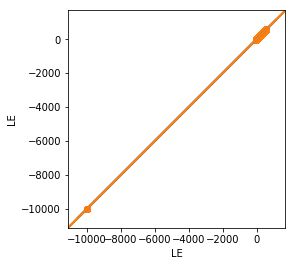

In [16]:
ax = sns.regplot(x="LE", y="LE", data=fr_df);
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [ ]:
'FIJok' 'ITCA2' 'IECa1' 'ITBCi' 'FRGri' 'FRAvi' 'ITCas' 'ESES2' 'BELon'
 'DERuS' 'UKESa' 'NLLan' 'ITRo3' 'UKHer' 'ITRo4' 'NLLut' 'NLMol' 'CHOe2'

In [10]:
df = Helpers.load_data("/Users/saraawad/Desktop/Datasets/Google/Euroflux/Processed\ Data/L2")
df_site = df_site["Site Id" == "BE-Lon"]
print(df_site["Year"].unique())

FileNotFoundError: [Errno 2] File b'/Users/saraawad/Desktop/Datasets/Google/Euroflux/Processed\\ Data/L2.csv' does not exist: b'/Users/saraawad/Desktop/Datasets/Google/Euroflux/Processed\\ Data/L2.csv'